In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline 

This example works with end-of-day (EOD) closing data for the EUR/USD exchange rate (tỉ lệ hối đoái của đồng Euro và đồng USD).

### 1. Import data

In [2]:
raw = pd.read_csv('Eikon EOD Data.csv', 
                 index_col = 0, parse_dates = True).dropna()

In [3]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  2516 non-null   float64
 1   MSFT.O  2516 non-null   float64
 2   INTC.O  2516 non-null   float64
 3   AMZN.O  2516 non-null   float64
 4   GS.N    2516 non-null   float64
 5   SPY     2516 non-null   float64
 6   .SPX    2516 non-null   float64
 7   .VIX    2516 non-null   float64
 8   EUR=    2516 non-null   float64
 9   XAU=    2516 non-null   float64
 10  GDX     2516 non-null   float64
 11  GLD     2516 non-null   float64
dtypes: float64(12)
memory usage: 255.5 KB


In [4]:
raw.head(3)

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-04,30.572827,30.95,20.88,133.90,173.08,113.33,1132.99,20.04,1.4411,1120.00,47.71,109.80
2010-01-05,30.625684,30.96,20.87,134.69,176.14,113.63,1136.52,19.35,1.4368,1118.65,48.17,109.70
2010-01-06,30.138541,30.77,20.80,132.25,174.26,113.71,1137.14,19.16,1.4412,1138.50,49.34,111.51


In [5]:
data = pd.DataFrame(raw['EUR='])    # (chọn cột EUR=) Transforms the Series object to a DataFrame object

In [6]:
data.head(3)

,EUR=
Date,
2010-01-04,1.4411
2010-01-05,1.4368
2010-01-06,1.4412


In [7]:
data.rename(columns = {'EUR=': 'price'}, inplace = True)    # Renames the only column to price

In [8]:
data.head(3)

,price
Date,
2010-01-04,1.4411
2010-01-05,1.4368
2010-01-06,1.4412


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   2516 non-null   float64
dtypes: float64(1)
memory usage: 39.3 KB


### 2. Calculation of SMAs

Calculation of SMAs using rolling() method: (ý tưởng là lấy trung bình cộng của các ngày trước đó)

In [10]:
data['SMA1'] = data['price'].rolling(42).mean()   # 42 days of SMA values, the first 42 values will be NaN

In [11]:
data['SMA2'] = data['price'].rolling(252).mean()  # 252 days of SMA values, the first 252 values will be NaN

In [12]:
data.tail()

,price,SMA1,SMA2
Date,,,
2019-12-24,1.1087,1.107698,1.119630
2019-12-26,1.1096,1.107740,1.119529
2019-12-27,1.1175,1.107924,1.119428
2019-12-30,1.1197,1.108131,1.119333
2019-12-31,1.1210,1.108279,1.119231


In [13]:
%matplotlib inline 
from pylab import mpl, plt 

plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300 
mpl.rcParams['font.family'] = 'serif'

<AxesSubplot:title={'center':'EUR/USD | 42 & 252 days SMAs'}, xlabel='Date'>

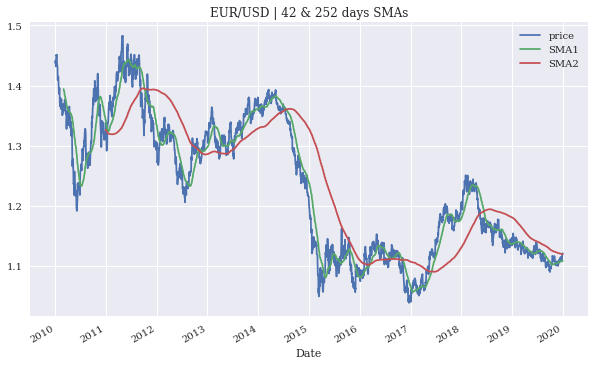

In [14]:
data.plot(title = 'EUR/USD | 42 & 252 days SMAs', 
          figsize = (10, 6))

### 3. Generate signals, or rather market positionings

Generate signals, or rather market positionings based on the relationship between the two SMAs.

Rule: go long whenever the shorter SMA (42 days) is above the longer one (252 days) and vice versa.

In [15]:
# compare two columns 
data['position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)  # if else code 

In [16]:
# Deletes all rows of the data set that contain at least one NaN value
data.dropna(inplace = True)

In [17]:
data.head(3)

,price,SMA1,SMA2,position
Date,,,,
2010-12-31,1.3377,1.342579,1.326218,1
2011-01-03,1.3351,1.340945,1.325798,1
2011-01-04,1.3301,1.338940,1.325374,1


<AxesSubplot:title={'center':'Market Positioning'}, xlabel='Date'>

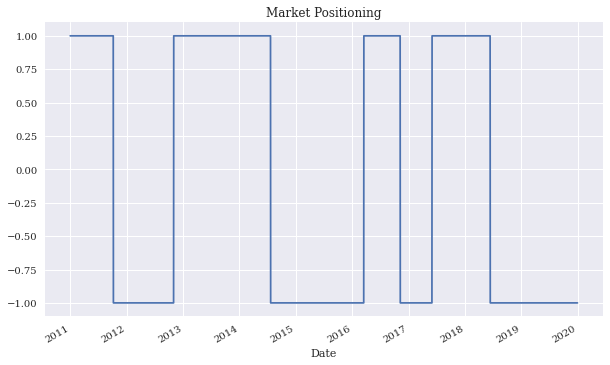

In [18]:
data['position'].plot(ylim = [-1.1, 1.1], 
                      title = 'Market Positioning', 
                      figsize = (10, 6))

### 4. Calculate the performance of the strategy

Calculate the log returns based on the original financial time series. 

In [19]:
data['returns'] = np.log(data['price'] / data['price'].shift(1))   # price day i + 1 / price day i

In [20]:
data.head(3)   # giá trị đầu tiên của returns sẽ là NaN, vì không có ngày trước ngày đó

,price,SMA1,SMA2,position,returns
Date,,,,,
2010-12-31,1.3377,1.342579,1.326218,1,NaN
2011-01-03,1.3351,1.340945,1.325798,1,-0.001946
2011-01-04,1.3301,1.338940,1.325374,1,-0.003752


<AxesSubplot:>

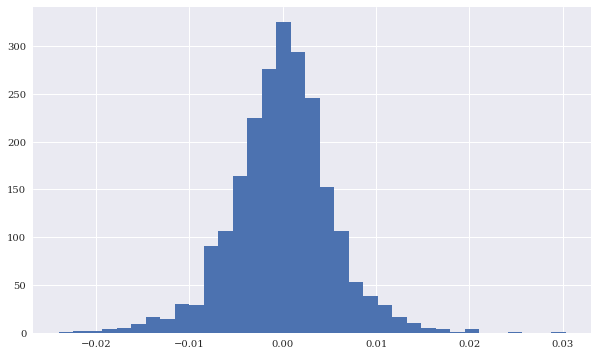

In [27]:
# plot the log returns as a histogram 
data['returns'].hist(bins = 35, figsize = (10, 6))  

### 5. Derive the strategy returns 

In [28]:
data.head(3)

,price,SMA1,SMA2,position,returns,strategy
Date,,,,,,
2010-12-31,1.3377,1.342579,1.326218,1,NaN,NaN
2011-01-03,1.3351,1.340945,1.325798,1,-0.001946,-0.001946
2011-01-04,1.3301,1.338940,1.325374,1,-0.003752,-0.003752


In [22]:
# derive the log returns of the strategy given the positionings and market returns 
data['strategy'] = data['position'].shift(1) * data['returns']

In [23]:
# sum up the single log return values for both the stock and the strategy
data[['returns', 'strategy']].sum()  

returns    -0.176731
strategy    0.253121
dtype: float64

=> The strategy books a win over the passive benchmark investment.

In [24]:
data[['returns', 'strategy']].sum().apply(np.exp)   # calculate gross performance (tổng lợi nhuận)

returns     0.838006
strategy    1.288039
dtype: float64

<AxesSubplot:xlabel='Date'>

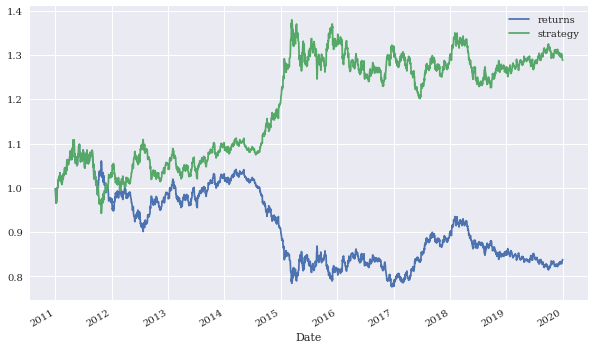

In [25]:
# tính tổng tích lũy 
data[['returns', 'strategy']].cumsum().apply(np.exp).plot(figsize = (10, 6))

=> SMA-based strategy có lợi nhuận tốt hơn so với lợi nhuận thông thường.

Nhận xét: Trong khoảng 9 năm, nhưng lợi nhuận chỉ được khoảng 0.3 -0.4 lần giá trị đầu tư. Theo mình thấy thì nó khá là ít.

In [30]:
data[['returns', 'strategy']].mean() * 252 

returns    -0.019671
strategy    0.028174
dtype: float64

In [31]:
np.exp(data[['returns', 'strategy']].mean() * 252) - 1

returns    -0.019479
strategy    0.028575
dtype: float64

In [33]:
data[['returns', 'strategy']].std() * 252 ** 0.5

returns     0.085414
strategy    0.085405
dtype: float64

In [35]:
(data[['returns', 'strategy']].apply(np.exp) - 1).std() * 252 ** 0.5

returns     0.085405
strategy    0.085373
dtype: float64

In [36]:
data['cumret'] = data['strategy'].cumsum().apply(np.exp)

In [37]:
data['cummax'] = data['cumret'].cummax()

In [38]:
data.head(3)

,price,SMA1,SMA2,position,returns,strategy,cumret,cummax
Date,,,,,,,,
2010-12-31,1.3377,1.342579,1.326218,1,NaN,NaN,NaN,NaN
2011-01-03,1.3351,1.340945,1.325798,1,-0.001946,-0.001946,0.998056,0.998056
2011-01-04,1.3301,1.338940,1.325374,1,-0.003752,-0.003752,0.994319,0.998056


<AxesSubplot:xlabel='Date'>

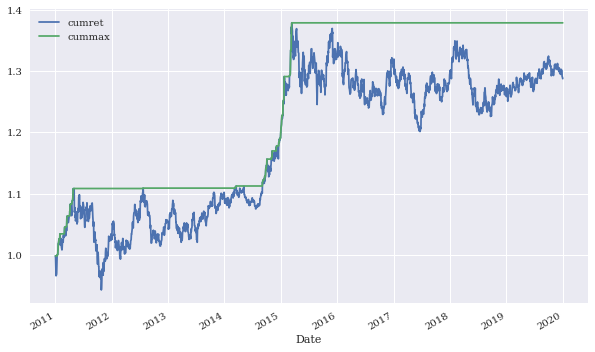

In [39]:
# cummulative return versus cummulative maximum return 
data[['cumret', 'cummax']].dropna().plot(figsize = (10, 6))

In [40]:
drawdown = data['cummax'] - data['cumret']

In [42]:
drawdown.head()

Date
2010-12-31         NaN
2011-01-03    0.000000
2011-01-04    0.003738
2011-01-05    0.014951
2011-01-06    0.026164
dtype: float64

In [43]:
drawdown.max()

0.17779367070195895